In [39]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys
import time

import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import words

## Part a: Extracting Language Features

In [40]:
# the interview data (sheet 1)
interview_data = pd.read_excel(
    "../data/DAIC_demographic_data.xlsx",
    sheet_name="Interview_Data",
    skiprows=lambda x: x == 1,
)
# drop the rows where data in column Partic# is NaN
interview_data = interview_data.dropna(subset=["Partic#"])
print(interview_data.tail())

# the phq score data (sheet 2)
phq_scores_data = pd.read_excel(
    "../data/DAIC_demographic_data.xlsx", sheet_name="Metadata_mapping"
)

#Convert Participant_ID column to string
phq_scores_data['Participant_ID'] = phq_scores_data['Participant_ID'].astype(str)

#Convert PHQ_Score to int
phq_scores_data['PHQ_Score'] = phq_scores_data['PHQ_Score'].astype(int)

print(phq_scores_data.head())

     Partic# Condition  gender  race
428    837.0        AI     2.0     3
429    838.0        AI     1.0     1
430    839.0        AI     1.0     1
431    840.0        AI     2.0     3
432    841.0        AI     1.0     4
  Participant_ID  PHQ_Score
0            300          2
1            301          3
2            302          4
3            303          0
4            304          6


The following step was a workaround to prevent the end of file error due to unclosed inverted commas. What the code is doing - opening and reading each file, reading each line and checking for lines that start with " but does not end with " (i.e., checking for unclosed quotes).

In [41]:
# preprocessing the csv files to remove the unclosed inverted commas
def clean_csv(file_path, output_path):
    with open(file_path, "r") as infile, open(output_path, "w") as outfile:
        for line in infile:
            if line.startswith('"') and not line.endswith('"\n'):
                line = line[1:]
            outfile.write(line)


def process_directory(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        if filename.endswith(".csv"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            clean_csv(input_path, output_path)


input_dir = "../data/E-DAIC_Transcripts"
output_dir = "../data/E-DAIC_Transcripts_cleaned"

process_directory(input_dir, output_dir)

In [42]:
cleaned_transcripts_path = "../data/E-DAIC_Transcripts_cleaned"

transcripts = {}

# loop through each file in the folder, load it, and store the content
for filename in os.listdir(cleaned_transcripts_path):
    if filename.endswith("_Transcript.csv"):
        participant_id = filename.split("_")[0]  # extract the participant id
        file_path = os.path.join(cleaned_transcripts_path, filename)

        df = pd.read_csv(file_path)
        transcripts[participant_id] = df

# transcripts
transcripts["386"]

,Text
0,might have pulled something that
1,I'm going to bring the great thanks so much
2,and please
3,are you okay with this yes
4,oh I'm fine I'm a little tired but I found ou...
...,...
76,yeah well after college people usually many p...
77,thank you goodbye
78,oh that was that was fast
79,but I didn't never said there wasn't any like...


The following cell is an intermediate step to the final feature extraction whereby all the transcripts have been compiled into a dictionary data structure.

In [43]:
# combine all the text data for each participant into a single string
combined_transcripts = {}

for participant_id, transcript in transcripts.items():
    combined_transcripts[participant_id] = " ".join(transcript["Text"].astype(str))

# removing extra spaces caused by newlines
for participant_id, transcript in combined_transcripts.items():
    combined_transcripts[participant_id] = " ".join(transcript.split())

# combined_transcripts

for participant_id, transcript in list(combined_transcripts.items())[:3]:
    print(participant_id, transcript)

423 okay and please yes feeling well where are you from originally Los Angeles the Greater Los Angeles area people diversity and various entertainment and activities fickle weather traffic and litter do you travel I have travel domestically not internationally seeing other places and how people live in the culture I want to hear about one of your trips the last trip that I went to a San Diego butt out from childhood or as an adult family vacations to Baja in Rosarito Beach can you tell me yeah the reason why that memory comes to mind because this weekend is Easter and we usually will go down to East Easter spring break to Rosarito Baja am I have a Bachelors in communication studies because of the open field just doesn't deal with them communication interactively but Performing Arts telecommunications business entrepreneurship so no I'm not at Maxey unemployed what's your dream job I think 200 my business that's my dream my dream job to have my own company I would like to open something

In [44]:
# combine the demographic data with the extracted text data

from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# create the feature extractor objects here; using the base settings for now

corpus = list(combined_transcripts.values())
tfidf_vectorizer = TfidfVectorizer(stop_words="english", token_pattern=r"\b[A-Za-z]+\b")
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

sentiment_analyzer = SentimentIntensityAnalyzer()

combined_data = []

# convert the participant id in demographic data to int for consistency
interview_data["Partic#"] = interview_data["Partic#"].astype(int)


for _, row in interview_data.iterrows():
    participant_id = str(row["Partic#"])  # convert id to match the transcript ids

    # find langauge features for this participant
    if participant_id in combined_transcripts:
        transcript = combined_transcripts[participant_id]

        # sentiment features
        sentiment_pos_scores = sentiment_analyzer.polarity_scores(transcript)["pos"]

        # sentiment features
        sentiment_neu_scores = sentiment_analyzer.polarity_scores(transcript)["neu"]

        # sentiment features
        sentiment_neg_scores = sentiment_analyzer.polarity_scores(transcript)["neg"]

        phq_score_row = phq_scores_data[phq_scores_data["Participant_ID"] == participant_id]
        if not phq_score_row.empty:
            phq_score = phq_score_row["PHQ_Score"].values[0]

        # combine all the features
        data = {
            "participant_id": participant_id,
            "condition": row["Condition"],
            "raceData": row["race"],
            "genderData": row["gender"],
            "phq_score": phq_score,
            # "tfidf_features": tfidf_features,
            # "count_features": count_features,
            "pos_sentiment": sentiment_pos_scores,
            "neu_sentiment": sentiment_neu_scores,
            "neg_sentiment": sentiment_neg_scores,
        }

        combined_data.append(data)

# convert the combined data into a dataframe
combined_data_df = pd.DataFrame(combined_data)

# print(combined_data_df.head())

# create dataframes for tf-idf and count features
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)

# concatenate the original DataFrame with the TF-IDF and Count DataFrames
final_df = pd.concat([combined_data_df.reset_index(drop=True), tfidf_df], axis=1)

final_df.head()

,participant_id,condition,raceData,genderData,phq_score,pos_sentiment,neu_sentiment,neg_sentiment,aa,aau,...,zip,ziplining,zipping,zodiac,zoloft,zombie,zone,zuma,zurich,zz
0,386,WoZ,3,2.0,11,0.184,0.770,0.046,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,387,WoZ,1,1.0,2,0.285,0.665,0.050,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,388,WoZ,4,1.0,17,0.161,0.769,0.070,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,389,WoZ,1,1.0,14,0.116,0.827,0.057,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,390,WoZ,3,1.0,9,0.193,0.740,0.067,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- By removing common stop words and number, we went from $8702$ features to $8299$ features.
- Each term in the TF-IDF vector is considered a feature. The values represent the TF-IDF score for that term. A higher score could mean that the term is important to the transcript but not common in the entire list of transcripts. This is helpful in identifying the transcript's topic/sentiment.
- Initially, we decided on using the compound score, but that resulting list of scores are heavily skewed. Figuring something might be wrong, we went back to using individual metrics (positive, negative and neutral).

We also noticed that using CountVectorizer just adds more columns to the dataframe, making the already sparse dataset more sparse. Therefore, I decided to not use it.

In [156]:
# looking at the top 10 words with the highest tf-idf scores

feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum the TF-IDF scores for each feature across all documents
tfidf_scores = np.sum(tfidf_matrix.toarray(), axis=0)

# Create a DataFrame with feature names and their corresponding scores
tfidf_scores_df = pd.DataFrame({"feature": feature_names, "score": tfidf_scores})

# Sort the DataFrame by scores in descending order
tfidf_scores_df = tfidf_scores_df.sort_values(by="score", ascending=False)

# Get the top 10 features
top_10_features = tfidf_scores_df.head(10)

# Display the top 10 features
print(top_10_features)

     feature      score
6326       s  35.261808
7293       t  32.736003
4428       m  29.000342
4287    like  24.292047
4058    just  23.032052
4129    know  22.186805
2193     don  17.789652
5934  really  16.630834
3160    good  12.510597
7451   think  10.710480


In [157]:
# checking to see the numer of stopwords removed

corpus = list(combined_transcripts.values())

# create a TfidfVectorizer without removing stop words
vectorizer_no_stop_words = TfidfVectorizer(token_pattern=r"\b[A-Za-z]+\b")
vectorizer_no_stop_words.fit(corpus)
vocab_no_stop_words = set(vectorizer_no_stop_words.get_feature_names_out())

# create a TfidfVectorizer with stop_words='english'
vectorizer_with_stop_words = TfidfVectorizer(
    stop_words="english", token_pattern=r"\b[A-Za-z]+\b"
)
vectorizer_with_stop_words.fit(corpus)
vocab_with_stop_words = set(vectorizer_with_stop_words.get_feature_names_out())

# find the difference between the two vocabularies
removed_stop_words = vocab_no_stop_words - vocab_with_stop_words

print("Removed stop words number:", len(removed_stop_words))

Removed stop words number: 272


In [158]:
# creating 5 folds with shuffled data

from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

folds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(final_df):
    train_fold = final_df.iloc[train_index]
    test_fold = final_df.iloc[test_index]
    folds.append((train_fold, test_fold))

# display the first fold
# train_fold, test_fold = folds[0]
# print("Train Fold:")
# print(train_fold.head())
# print("\nTest Fold:")
# print(test_fold.head())

for i, (train_fold, test_fold) in enumerate(folds):
    print(f"Fold {i+1}:")
    print(f"Train Fold Size: {len(train_fold)}")
    print(f"Test Fold Size: {len(test_fold)}\n")

Fold 1:
Train Fold Size: 152
Test Fold Size: 38

Fold 2:
Train Fold Size: 152
Test Fold Size: 38

Fold 3:
Train Fold Size: 152
Test Fold Size: 38

Fold 4:
Train Fold Size: 152
Test Fold Size: 38

Fold 5:
Train Fold Size: 152
Test Fold Size: 38



### Optional: Doing more preprocessing to remove non-English words

_I used the NLTK library to exclude non-English words from the corpus. This reduces the number of features significantly, as you'll see below. I'm still not sure about removing the stop words though; you can try and see if disabling it helps with the performance._

_You can use this dataset to do the rest of the tasks. I only included this because I figured it might help with overfitting and consequentially, improve the model accuracies._

_For the folds, I have used the `final_df` dataset, which is the one that has $8306$ features. If you want, you can use the dataframe with the non-English words removed._

In [159]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download("words")

eng_words = set(words.words())

# preprocessing function


def preprocess_text(text):
    text = re.sub(r"\d+", "", text)  # Remove numbers
    tokens = re.findall(r"\b\w+\b", text)  # Tokenize
    valid_words = [
        token for token in tokens if token.lower() in eng_words
    ]  # Filter non-English words
    return " ".join(valid_words)


# create the feature extractor objects here; using the base settings for now

# corpus = list(combined_transcripts.values())
processed_corpus = [preprocess_text(text) for text in corpus]
tfidf_vectorizer_ = TfidfVectorizer(stop_words="english")
tfidf_matrix_ = tfidf_vectorizer_.fit_transform(processed_corpus)

sentiment_analyzer_ = SentimentIntensityAnalyzer()

combined_data_ = []

# convert the participant id in demographic data to int for consistency
interview_data["Partic#"] = interview_data["Partic#"].astype(int)


for _, row in interview_data.iterrows():
    participant_id = str(row["Partic#"])  # convert id to match the transcript ids

    # find langauge features for this participant
    if participant_id in combined_transcripts:
        transcript = combined_transcripts[participant_id]

        # sentiment features
        sentiment_pos_scores = sentiment_analyzer.polarity_scores(transcript)["pos"]

        # sentiment features
        sentiment_neu_scores = sentiment_analyzer.polarity_scores(transcript)["neu"]

        # sentiment features
        sentiment_neg_scores = sentiment_analyzer.polarity_scores(transcript)["neg"]

        phq_score_row = phq_scores_data[phq_scores_data["Participant_ID"] == participant_id]
        if not phq_score_row.empty:
            phq_score = phq_score_row["PHQ_Score"].values[0]

        # combine all the features
        data = {
            "participant_id": participant_id,
            "condition": row["Condition"],
            "raceData": row["race"],
            "genderData": row["gender"],
            "phq_score": phq_score,
            # "tfidf_features": tfidf_features,
            # "count_features": count_features,
            "pos_sentiment": sentiment_pos_scores,
            "neu_sentiment": sentiment_neu_scores,
            "neg_sentiment": sentiment_neg_scores,
        }

        combined_data_.append(data)

# convert the combined data into a dataframe
combined_data_df_ = pd.DataFrame(combined_data_)

# print(combined_data_df.head())

# create dataframes for tf-idf and count features
tfidf_df_ = pd.DataFrame(
    tfidf_matrix_.toarray(), columns=tfidf_vectorizer_.get_feature_names_out()
)

# concatenate the original DataFrame with the TF-IDF and Count DataFrames
final_df_ = pd.concat([combined_data_df_.reset_index(drop=True), tfidf_df_], axis=1)

final_df_.head()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Noah\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


,participant_id,condition,raceData,genderData,phq_score,pos_sentiment,neu_sentiment,neg_sentiment,aa,abandoned,...,youth,yule,zany,zero,zest,zip,zipping,zodiac,zombie,zone
0,386,WoZ,3,2.0,11,0.184,0.770,0.046,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,387,WoZ,1,1.0,2,0.285,0.665,0.050,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,388,WoZ,4,1.0,17,0.161,0.769,0.070,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,389,WoZ,1,1.0,14,0.116,0.827,0.057,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,390,WoZ,3,1.0,9,0.193,0.740,0.067,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


By excluding non-english words, along with removing stop words, I was able to reduce the number of features significantly - from $8299$ to $5327$. This may produce better results.

In [160]:
feature_names_ = tfidf_vectorizer_.get_feature_names_out()

# Sum the TF-IDF scores for each feature across all documents
tfidf_scores_ = np.sum(tfidf_matrix_.toarray(), axis=0)

# Create a DataFrame with feature names and their corresponding scores
tfidf_scores_df_ = pd.DataFrame({"feature": feature_names_, "score": tfidf_scores_})

# Sort the DataFrame by scores in descending order
tfidf_scores_df_ = tfidf_scores_df_.sort_values(by="score", ascending=False)

# Get the top 10 features
top_10_features_ = tfidf_scores_df_.head(10)

# Display the top 10 features
print(top_10_features_)

     feature      score
2752    like  29.028222
2612    just  27.465559
2650    know  26.661350
1405     don  21.508594
3770  really  19.885133
2048    good  14.995024
4768   think  12.867584
3400  people  12.553898
4795    time  12.395769
2044   going  11.075604


## Part b: Classifying by Gender

Classifying for gender. Use one tree-based ML model of your choice and one deep learning ML model of your choice to classify participants in terms of gender. Explore a filter feature selection method of your choice to identify the n features that are the most informative of gender based on the provided data. Experiment with different values of n. Please report the simple classification accuracy A and balanced classification accuracy BA.

The first step is the extract the dataset. I first drop the race, condition, and participant IDs from the data set. Then I drop all rows with NaN values. I then map the gender values from the range [1, 2] to [0, 1] (this works better in XGBoost). Lastly, I store the gender as the target value.

In [161]:
# remove non-language features
useNonEnglishWordRemovalDatasetFlag = False
if useNonEnglishWordRemovalDatasetFlag:
    genderDF = final_df_.drop(["raceData", "condition", "participant_id", "phq_score"], axis=1)
else:
    genderDF = final_df.drop(["raceData", "condition", "participant_id", "phq_score"], axis=1)

# remove rows with NaN
genderDF = genderDF.dropna()

# map gender from [1,2] -> [0,1] (XGBoost needs the labels to be 0 or 1)
genderDF["genderData"] = genderDF["genderData"].map({1: 0, 2: 1})

# store target data
targetGender = genderDF.pop("genderData")

The next step is to find the Pearson's correlation coefficient between each feature and the gender target value

In [162]:
# use pearsonr API
from scipy.stats import pearsonr

# loop over all features and find the pearson's coefficient
genderCorr = []
for i, (cols) in enumerate(genderDF.columns):

    corr, p = pearsonr(genderDF[cols], targetGender)
    genderCorr.append(corr)

genderCorr = np.array(genderCorr)

In [163]:
# check if any NaN values and set them to -1
genderCorr[np.isnan(genderCorr)] = -1

In [164]:
# find the indcieis of the descended sorted array
idx = np.argsort(genderCorr)
idx = idx[::-1]

# extract the features with the top 10 pearson's coefficient
top10Cols = genderDF.columns[idx[:10]].tolist()
top10Scores = np.sort(genderCorr)
top10Scores = top10Scores[::-1]
top10Scores = top10Scores[:10]

# print the features
print("Top 10 Pearson's Coefficients: ")
print("------------------------------")
for ii in range(10):
    print(f"{top10Cols[ii]}: {top10Scores[ii]}")

Top 10 Pearson's Coefficients: 
------------------------------
interested: 0.3216223838313521
boyfriend: 0.30847090696221235
making: 0.29691852364308696
husband: 0.27878221947259696
class: 0.26253202139488074
child: 0.26227243387190746
quickly: 0.2556227327674824
love: 0.2480364999027526
think: 0.24425767597738657
really: 0.24380424882054946


The next step is to create the 5 folds to be used in cross validation

In [165]:
from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

genderFolds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(genderDF):
    train_fold = genderDF.iloc[train_index]
    test_fold = genderDF.iloc[test_index]
    train_target_fold = targetGender.iloc[train_index]
    test_target_fold = targetGender.iloc[test_index]
    genderFolds.append((train_fold, train_target_fold, test_fold, test_target_fold))

# print the fold statistics
for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(genderFolds):
    print(f"Fold {i+1}:")
    print(f"Train Fold Size: {len(train_fold)}")
    print(f"Test Fold Size: {len(test_fold)}\n")

Fold 1:
Train Fold Size: 150
Test Fold Size: 38

Fold 2:
Train Fold Size: 150
Test Fold Size: 38

Fold 3:
Train Fold Size: 150
Test Fold Size: 38

Fold 4:
Train Fold Size: 151
Test Fold Size: 37

Fold 5:
Train Fold Size: 151
Test Fold Size: 37



Then we define a helper function to calculate accuracy and and balanced accuracy

In [166]:
# helper function to calcualte accuracy and balanced accuracy
def getAccAndBAcc(yPred, yTrue):

    truePos = 0
    trueNeg = 0
    falsePos = 0
    falseNeg = 0

    for idx in range(len(yPred)):
        
        if yPred[idx] == 1:

            if yTrue[idx] == 1:

                truePos += 1

            else:

                falseNeg += 1

        else:

            if yTrue[idx] == 1:

                falsePos += 1

            else:

                trueNeg += 1

    if (trueNeg+falsePos) == 0 and (truePos+falseNeg) != 0:
        balancedAccuracy = 0.5*truePos/(truePos+falseNeg)
    elif (trueNeg+falsePos) != 0 and (truePos+falseNeg) == 0:
        balancedAccuracy = 0.5*trueNeg/(trueNeg+falsePos)
    else:
        balancedAccuracy = 0.5*trueNeg/(trueNeg+falsePos) + 0.5*truePos/(truePos+falseNeg)
    
    accuracy = (truePos + trueNeg) / (truePos + trueNeg + falsePos + falseNeg)

    return accuracy, balancedAccuracy

Next, the Deep Learning model is defined. For this part we are using a FFN.

In [167]:
# create deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def getDLModel(inputShape):

    model = Sequential([
        Dense(128, activation='relu', input_shape=(inputShape,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics = ["accuracy"]
    )

    return model

Next we perform cross validation over the 5 folds. We first loop over the number of features to train on. Then we calculate the accuracy and balanced accuracy for all 5 folds and then store off the average accuracy and balanced accuracy for both the feed forward and XGBoost models.

We then conclude the best number of features is that which corresponds to the highest average balanced accuracy.

In [168]:
import xgboost as xgb

# define number of features to perform cross validation on
numberOfFeatures = [len(genderDF.columns)-1, 4000, 3000, 2000, 1000, 500, 100, 50]

# instantiaite accuracy arrays
bAccTree = []
accTree  = []
bAccDL = []
accDL  = []

# define lambda function to get the top N indicies
top_n_idx = lambda data, n: np.argsort(data)[-n:]

# loop over number of top features
for n in numberOfFeatures:

    # get the indicies of top N features
    nIdx = top_n_idx(genderCorr, n)

    # get top columns
    nCols = genderDF.columns[nIdx]

    # instantiate fold accuracy arrays
    foldAccTree = []
    foldBAccTree = []
    foldAccDL = []
    foldBAccDL = []

    # loop over folds
    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(genderFolds):

        # filter out top columns to train on and test
        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # train XGBoost model
        xgb_classifier = xgb.XGBClassifier()
        xgb_classifier.fit(train_fold, train_target_fold)

        # get test accuracy and balanced accuracy
        acc, bAcc = getAccAndBAcc(xgb_classifier.predict(test_fold), test_target_fold.to_numpy())

        # store accuracies
        foldAccTree.append(acc)
        foldBAccTree.append(bAcc)

        # train DL model
        FNN = getDLModel(train_fold.shape[1])
        FNN.fit(train_fold, train_target_fold, epochs=10, verbose=0)

        # get test accuracy and balanced accuracy
        yPred = FNN.predict(test_fold)
        yPred[yPred > 0.5] = 1
        yPred[yPred < 0.5] = 0
        acc, bAcc = getAccAndBAcc(yPred, test_target_fold.to_numpy())

        # store accuracies
        foldAccDL.append(acc)
        foldBAccDL.append(bAcc)

    # calculate average values
    accTree.append(np.mean(foldAccTree))
    bAccTree.append(np.mean(foldBAccTree))
    accDL.append(np.mean(foldAccDL))
    bAccDL.append(np.mean(foldBAccDL))

# show all average balanced and average accuracies
print("\n")
for idx in range(len(numberOfFeatures)):

    print("#######################################")
    print(f"Values for {numberOfFeatures[idx]} top features:")
    print(f"Tree accuracy: {accTree[idx]}")
    print(f"Tree balanced accuracy: {bAccTree[idx]}")
    print(f"DL accuracy: {accDL[idx]}")
    print(f"DL balanced accuracy: {bAccDL[idx]}")

# print best balanced accuracy for XGBoost and DL model
maxTreeBAccNumFeatures = numberOfFeatures[np.argmax(bAccTree)]
maxDLBAccNumFeatures = numberOfFeatures[np.argmax(bAccDL)]
print("\n")
print("#######################################")
print(f"Max Tree Number of Features: {maxTreeBAccNumFeatures}, with balanced accuracy of {np.max(bAccTree) * 100}%")
print(f"Max DL Number of Features: {maxDLBAccNumFeatures}, with balanced accuracy of {np.max(bAccDL) * 100}%")
print("#######################################")
    

2/2 [==============================] - 0s 2ms/step


#######################################
Values for 8300 top features:
Tree accuracy: 0.6812233285917497
Tree balanced accuracy: 0.6739812039812039
DL accuracy: 0.6537695590327168
DL balanced accuracy: 0.6907110727110727
#######################################
Values for 4000 top features:
Tree accuracy: 0.6490753911806543
Tree balanced accuracy: 0.6501583984342606
DL accuracy: 0.579800853485064
DL balanced accuracy: 0.3518177199756147
#######################################
Values for 3000 top features:
Tree accuracy: 0.6223328591749644
Tree balanced accuracy: 0.6043737228607918
DL accuracy: 0.6167852062588904
DL balanced accuracy: 0.48593833067517284
#######################################
Values for 2000 top features:
Tree accuracy: 0.7237553342816501
Tree balanced accuracy: 0.7313808260704813
DL accuracy: 0.8140825035561878
DL balanced accuracy: 0.8853349989111946
#######################################
Values for 1000 top feature

The max XGBoost balanced accuracy was 77.8% with 100 top features and the max DL balanced accuracy was 89.5% with 500 top features.

Finally, we plot the results for the balanced accuracy and accuracy for both the XGBoost and FFN

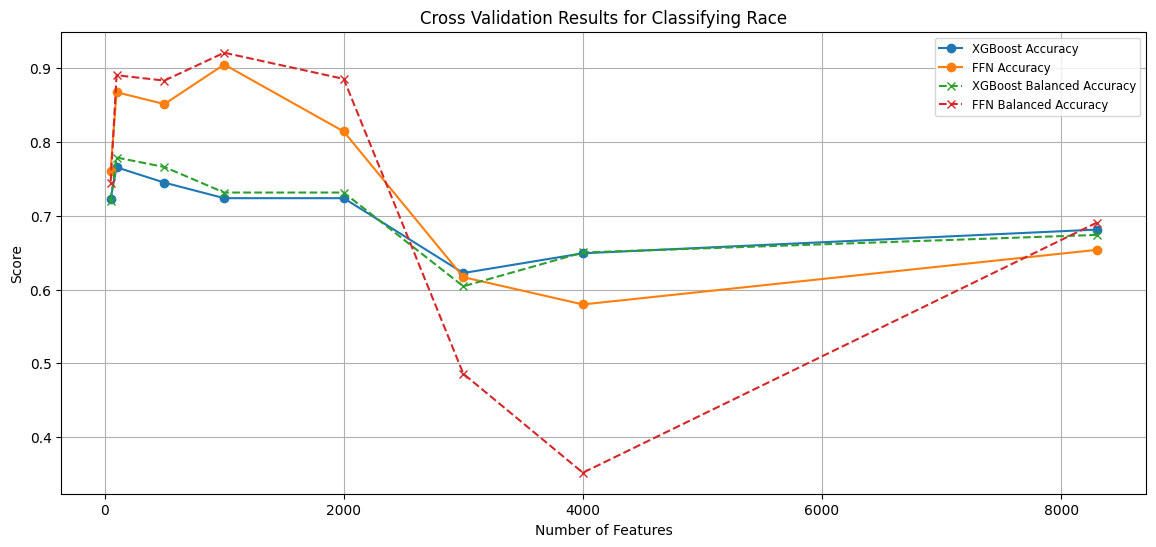

In [169]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 6))
plt.title("Cross Validation Results for Classifying Race")

# Plot accuracy metrics
plt.plot(numberOfFeatures, accTree, label="XGBoost Accuracy", marker='o')
plt.plot(numberOfFeatures, accDL, label="FFN Accuracy", marker='o')

# Plot balanced accuracy metrics
plt.plot(numberOfFeatures, bAccTree, label="XGBoost Balanced Accuracy", linestyle='--', marker='x')
plt.plot(numberOfFeatures, bAccDL, label="FFN Balanced Accuracy", linestyle='--', marker='x')

# Add labels, legend, and grid
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.legend(loc='best', fontsize='small')
plt.grid(True)

# Show plot
plt.show()

## Part c: Classifying by Race

To classify for race I used two models. LightBoost, a flavor of XGBoost and an FNN for classification. The Lightboost models is because after data exploration there was a class imbalance for the races in the dataset. The FNN was kept simple due to the small amounts of data available. To create the dataset, i took the top 500 informative features (summed for all patients) and iterated through feature amounts.

In [170]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Attention, Flatten, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [171]:
def getAccAndBAcc_multi_class(yPred, yTrue):
    acc = accuracy_score(yPred, yTrue)
    bAcc = balanced_accuracy_score(yPred, yTrue)
    return acc, bAcc

## Data
For my features and data I took the 500 most informative features from the TFIDF process and sorted them from best to worst. I did this has many of the words/features from the TFIDF process had very low scores, may had very similar scores so getting the top 500 should provide the model with the most informative data, while staying at a reasonable size of data.

In [172]:
global_feature_importance = tfidf_df.sum(axis=0)
top_features = global_feature_importance.sort_values(ascending=False)
top_feature_names = top_features.head(500).index
top_feature_names

Index(['s', 't', 'm', 'like', 'just', 'know', 'don', 'really', 'good', 'think',
       ...
       'traveled', 'cranky', 'leaving', 'service', 'ideal', 'watching',
       'virtual', 'drinking', 'loving', 'boys'],
      dtype='object', length=500)

In [173]:
reduced_tfidf_df = tfidf_df[top_feature_names]
dataset = pd.concat([combined_data_df.reset_index(drop=True), reduced_tfidf_df.reset_index(drop=True)], axis=1)
dataset

,participant_id,condition,raceData,genderData,phq_score,pos_sentiment,neu_sentiment,neg_sentiment,s,t,...,traveled,cranky,leaving,service,ideal,watching,virtual,drinking,loving,boys
0,386,WoZ,3,2.0,11,0.184,0.770,0.046,0.419840,0.227126,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,387,WoZ,1,1.0,2,0.285,0.665,0.050,0.161978,0.179976,...,0.000000,0.0,0.000000,0.000000,0.060506,0.000000,0.000000,0.000000,0.113789,0.0
2,388,WoZ,4,1.0,17,0.161,0.769,0.070,0.123940,0.247879,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,389,WoZ,1,1.0,14,0.116,0.827,0.057,0.086892,0.278054,...,0.000000,0.0,0.053425,0.000000,0.058424,0.000000,0.000000,0.000000,0.000000,0.0
4,390,WoZ,3,1.0,9,0.193,0.740,0.067,0.231981,0.139189,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,713,AI,3,NaN,0,0.120,0.800,0.080,0.196392,0.310954,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
186,715,AI,1,1.0,0,0.135,0.813,0.051,0.241285,0.232005,...,0.027787,0.0,0.000000,0.028151,0.000000,0.000000,0.000000,0.030697,0.000000,0.0
187,716,AI,4,1.0,0,0.161,0.730,0.109,0.287707,0.362298,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.037079,0.000000,0.000000,0.0
188,717,AI,1,1.0,0,0.152,0.791,0.058,0.216291,0.243327,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [174]:
race_df = dataset.drop(["condition", "participant_id", "phq_score"], axis=1)
race_df = race_df.dropna()
y_race = race_df.pop("raceData")
y_race = y_race - 1

In [175]:
race_df.shape, y_race.shape

((188, 504), (188,))

## FNN

After trying more complex models and getting bad results, low bAcc and Acc almost similar to classifying race by chance, I started making the models simpler and started to get better results. I believe this is due to the amount of data available as well model archicture. I think if we had more data and a different model architecture(I have seen people use a CNN to classify numeric data, I think its the max pooling that might make a CNN useful), the results would be better.

In [176]:
def get_dense_model(input_shape):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(7, activation="softmax")  # 7 classes
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [177]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
race_folds = []

for train_index, test_index in skf.split(race_df, y_race):
    # print(train_index, test_index)
    train_fold = race_df.iloc[train_index]
    test_fold = race_df.iloc[test_index]
    train_target_fold = y_race.iloc[train_index]
    test_target_fold = y_race.iloc[test_index]
    race_folds.append((train_fold, train_target_fold, test_fold, test_target_fold))

In [178]:
correlation_df = race_df.corrwith(y_race)
correlation_df = correlation_df.reset_index()
correlation_df.columns = ['Feature', 'Correlation']

In [179]:
race_corr = correlation_df["Correlation"].dropna()
race_corr = race_corr.tolist()

In [180]:
idx = np.argsort(race_corr)
idx = idx[::-1]

top10Cols = race_df.columns[idx[:20]].tolist()
top10Scores = np.sort(race_corr)
top10Scores = top10Scores[::-1]
top10Scores = top10Scores[:20]

print("Most Correlated Values")
for ii in range(10):
    print(f"{top10Cols[ii]}: {top10Scores[ii]}")

Most Correlated Values
talking: 0.30809746727549736
help: 0.2693416873277965
issues: 0.256741469351594
tend: 0.24479572048739132
party: 0.20437963329469575
decided: 0.19056534032380162
movie: 0.187357032837464
comfortable: 0.1868175030689815
better: 0.18432896079045094
lack: 0.1833755239258952


In [181]:
for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(race_folds):
    print(f"Fold {i + 1} - Train classes: {train_target_fold.unique()}, Test classes: {test_target_fold.unique()}")

Fold 1 - Train classes: [0 3 2 1 6 4 5], Test classes: [2 0 3 6 4 1]
Fold 2 - Train classes: [2 0 3 6 1 4 5], Test classes: [3 0 1 2 6 4]
Fold 3 - Train classes: [2 0 3 6 1 4], Test classes: [2 0 3 6 1 5]
Fold 4 - Train classes: [2 3 0 6 1 4 5], Test classes: [0 2 3 1 6]
Fold 5 - Train classes: [2 0 3 6 1 4 5], Test classes: [3 2 6 0 1 4]


## Data p2
Above is doing more data analysis on the most correlated values, I thought visualizing the most correlated ones would help me understand the data better and what the model might look for when learning the data. I then looked at the class imbalance from splitting the data into 5 different folds. Not all folds contain all classes, after researching many ways to try and fix this, I determined that because of the class imbalance and ways to fix it being out of scope, I went with a different model. At first I tried using XGBoost since that is a widely used, very good tree + boosting model, but XGBoost needs all classes to be in all folds. After doing research online I found LightGBM, which is a GB flavor of XGBoost. LightGBM is better for missing classes when treating it as a classifier, but has downsides such as it the algorithm is easier to overfit compared to XGBoost.

In [182]:
numberOfFeatures = [len(race_df.columns)-1, 400, 300, 200, 100, 50]

In [183]:
accTree = []
bAccTree = []

for n in numberOfFeatures:

    nCols = race_df.columns[:n]

    # print("NCOLS \n",nCols)

    foldAccTree = []
    foldBAccTree = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(race_folds):

        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # print(f"train_fold shape: \n{train_fold.shape}")
        # print(f"train_target_fold shape: \n{train_target_fold.shape}")
        # print(f"test_fold shape: \n{test_fold.shape}")
        # print(f"test_target_fold shape: \n{test_target_fold.shape}")

        train_data = lgb.Dataset(train_fold, label=train_target_fold)
        test_data = lgb.Dataset(test_fold, label=test_target_fold)

        # try random stuff to see if it works
        params = {
            'objective': 'multiclass',
            'num_class': 7,
            'metric': 'multi_logloss',
            'is_unbalance': True,  # Address class imbalance
            'boosting_type': 'gbdt',
            'learning_rate': 0.001,
            'max_depth': 8,
            'num_leaves': 30,
            'verbose': -1
        }

        lgb_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

        predictions = lgb_model.predict(test_fold)
        predicted_classes = predictions.argmax(axis=1)
        acc, bAcc = getAccAndBAcc_multi_class(predicted_classes, test_target_fold.to_numpy())

        foldAccTree.append(acc)
        foldBAccTree.append(bAcc)

    accTree.append(np.mean(foldAccTree))
    bAccTree.append(np.mean(foldBAccTree))

In [184]:
bAccDL = []
accDL = []

for n in numberOfFeatures:

    nCols = race_df.columns[:n]

    foldAccDL = []
    foldBAccDL = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(race_folds):

        # Use only top-n columns
        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # Train Dense Neural Network
        FNN = get_dense_model(train_fold.shape[1])
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
        ]
        # print("TF \n", train_fold, "\n")
        # print("TRAIN target \n", train_target_fold, "\n")
        # print("TEST target \n", test_target_fold)
        # callbacks=callbacks,
        FNN.fit(train_fold, train_target_fold, validation_split=0.2, callbacks=callbacks, epochs=100,  verbose=0)

        # Evaluate Dense Neural Network
        fnn_predictions = FNN.predict(test_fold).argmax(axis=1)
        # print(fnn_predictions)
        acc, bAcc = getAccAndBAcc_multi_class(fnn_predictions, test_target_fold.to_numpy())

        foldAccDL.append(acc)
        foldBAccDL.append(bAcc)

    accDL.append(np.mean(foldAccDL))
    bAccDL.append(np.mean(foldBAccDL))

2/2 [==============================] - 0s 1ms/step


In [185]:
print("\n")
for idx in range(len(numberOfFeatures)):

    print("#######################################")
    print(f"Values for {numberOfFeatures[idx]} top features:")
    print(f"Tree accuracy: {accTree[idx]}")
    print(f"Tree balanced accuracy: {bAccTree[idx]}")
    print(f"DL accuracy: {accDL[idx]}")
    print(f"DL balanced accuracy: {bAccDL[idx]}")


maxTreeBAccNumFeatures = numberOfFeatures[np.argmax(bAccTree)]
maxDLBAccNumFeatures = numberOfFeatures[np.argmax(bAccDL)]

print("\n")
print("#######################################")
print(f"Max Tree Number of Features: {maxTreeBAccNumFeatures}, with balanced accuracy of {np.max(bAccTree) * 100}%")
print(f"Max DL Number of Features: {maxDLBAccNumFeatures}, with balanced accuracy of {np.max(bAccDL) * 100}%")
print("#######################################")



#######################################
Values for 503 top features:
Tree accuracy: 0.4095305832147938
Tree balanced accuracy: 0.4095305832147938
DL accuracy: 0.4307254623044098
DL balanced accuracy: 0.49378436878436877
#######################################
Values for 400 top features:
Tree accuracy: 0.4095305832147938
Tree balanced accuracy: 0.4095305832147938
DL accuracy: 0.44139402560455193
DL balanced accuracy: 0.3677979251541664
#######################################
Values for 300 top features:
Tree accuracy: 0.4095305832147938
Tree balanced accuracy: 0.4095305832147938
DL accuracy: 0.4416785206258891
DL balanced accuracy: 0.5556458406458408
#######################################
Values for 200 top features:
Tree accuracy: 0.4095305832147938
Tree balanced accuracy: 0.4095305832147938
DL accuracy: 0.42019914651493606
DL balanced accuracy: 0.4335357471580382
#######################################
Values for 100 top features:
Tree accuracy: 0.4147937411095306
Tree balanced ac

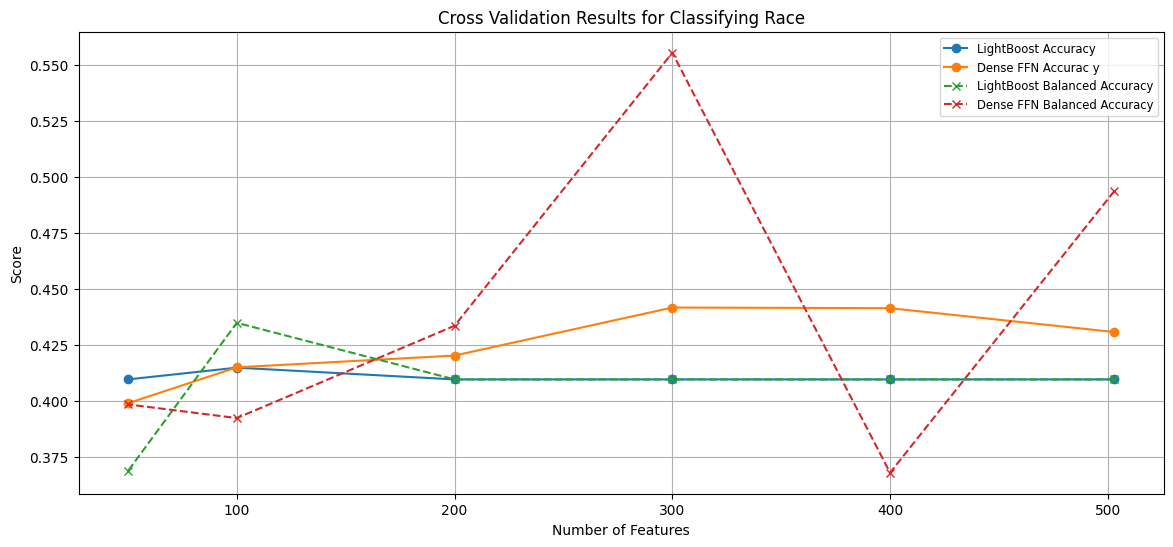

In [186]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 6))
plt.title("Cross Validation Results for Classifying Race")

# Plot accuracy metrics
plt.plot(numberOfFeatures, accTree, label="LightBoost Accuracy", marker='o')
plt.plot(numberOfFeatures, accDL, label="Dense FFN Accurac y", marker='o')

# Plot balanced accuracy metrics
plt.plot(numberOfFeatures, bAccTree, label="LightBoost Balanced Accuracy", linestyle='--', marker='x')
plt.plot(numberOfFeatures, bAccDL, label="Dense FFN Balanced Accuracy", linestyle='--', marker='x')

# Add labels, legend, and grid
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.legend(loc='best', fontsize='small')
plt.grid(True)

# Show plot
plt.show()

## Results
The first set of results I got from my first set of models + data was terrible, that graph is in the presentation slides and each model was pretty much just random chance at classifying. After redoing both the data I was using and the model architectures, my results improved. As we can see the best for the FNN was around 300 features with really high balanced accuracyand the best overall accuracy. For the tree model, the best was 100 features. I think this is due to overfitting (LightGBM is biased towards overfitting) and the small amount of data. I think that for the FNN, it could do better with better, more thought out model architecture and the tree model needs some extra fine fine-tuning of its model architecture with data amount this low.

## Part d: Estimating Depression Severity

In [187]:
from scipy.stats import pearsonr

phqDF = final_df.drop(["raceData", "condition", "participant_id", "genderData"], axis=1)

targetPHQ = phqDF.pop("phq_score")

phqCorr = []

for i, (cols) in enumerate(phqDF.columns):

    corr, p = pearsonr(phqDF[cols], targetPHQ)
    if np.isnan(corr):
        corr = 0
    phqCorr.append(corr)


def absRelErr(yPred, yTrue):
    return np.mean(np.abs(yPred - yTrue) / np.max(yTrue)), pearsonr(yPred, yTrue)[0]

In [188]:
from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

phqFolds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(phqDF):
    train_fold = phqDF.iloc[train_index]
    test_fold = phqDF.iloc[test_index]
    train_target_fold = targetPHQ.iloc[train_index]
    test_target_fold = targetPHQ.iloc[test_index]
    phqFolds.append((train_fold, train_target_fold, test_fold, test_target_fold))

for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(phqFolds):
    print(f"Fold {i+1}:")
    print(f"Train Fold Size: {len(train_fold)}")
    print(f"Test Fold Size: {len(test_fold)}\n")

Fold 1:
Train Fold Size: 152
Test Fold Size: 38

Fold 2:
Train Fold Size: 152
Test Fold Size: 38

Fold 3:
Train Fold Size: 152
Test Fold Size: 38

Fold 4:
Train Fold Size: 152
Test Fold Size: 38

Fold 5:
Train Fold Size: 152
Test Fold Size: 38



In [189]:
# create deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def getDLModel(inputShape):

    model = Sequential([
        Dense(64, activation='relu', input_shape=(inputShape,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation="linear")
    ])

    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics = ["accuracy"]
    )

    return model

In [190]:
import xgboost as xgb

numberOfFeatures = [50, 75, 100, 125, 150, 200, 500]

reTree = []
rTree  = []

reDL = []
rDL  = []

top_n_idx = lambda data, n: np.argsort(data)[-n:]

for n in numberOfFeatures:

    nIdx = top_n_idx(phqCorr, n)

    nCols = phqDF.columns[nIdx]

    foldReTree = []
    foldRTree = []

    foldReDL = []
    foldRDL = []

    for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(phqFolds):

        train_fold = train_fold[nCols]
        test_fold = test_fold[nCols]

        # train XGBoost model
        xgb_regressor = xgb.XGBRegressor()
        xgb_regressor.fit(train_fold, train_target_fold)

        relErr, r = absRelErr(xgb_regressor.predict(test_fold), test_target_fold.to_numpy())
        
        # store accuracies
        foldReTree.append(relErr)
        foldRTree.append(r)

        # train DL model
        FNN = getDLModel(train_fold.shape[1])
        FNN.fit(train_fold, train_target_fold, epochs=100, verbose=0)

        # get test accuracy and balanced accuracy
        relErr, r = absRelErr(FNN.predict(test_fold).flatten(), test_target_fold.to_numpy())

        # store accuracies
        foldReDL.append(relErr)
        foldRDL.append(r)
        
    reTree.append(np.mean(foldReTree))
    rTree.append(np.mean(foldRTree))
    
    reDL.append(np.mean(foldReDL))
    rDL.append(np.mean(foldRDL))

print("\n")
for idx in range(len(numberOfFeatures)):

    print("#######################################")
    print(f"Values for {numberOfFeatures[idx]} top features:")
    print(f"Tree Absolute Relative Error: {reTree[idx]}")
    print(f"Tree Pearson Coefficient: {rTree[idx]}")
    print(f"DL Absolute Relative Error: {reDL[idx]}")
    print(f"DL Pearson Coefficient: {rDL[idx]}")


minTreeReNumFeatures = numberOfFeatures[np.argmin(reTree)]
minDLReNumFeatures = numberOfFeatures[np.argmin(reDL)]

print("\n")
print("#######################################")
print(f"Min Tree Number of Features: {minTreeReNumFeatures}, with Absolute Relative Error of {np.min(reTree)}")
print(f"Min DL Number of Features: {minDLReNumFeatures}, with Absolute Relative Error of {np.min(reDL)}")
print("#######################################")

2/2 [==============================] - 0s 1000us/step


#######################################
Values for 50 top features:
Tree Absolute Relative Error: 0.23243526210389348
Tree Pearson Coefficient: 0.26859203532828124
DL Absolute Relative Error: 0.25386980687134325
DL Pearson Coefficient: 0.505259827482908
#######################################
Values for 75 top features:
Tree Absolute Relative Error: 0.23243526210389348
Tree Pearson Coefficient: 0.26859203532828124
DL Absolute Relative Error: 0.2607017069713711
DL Pearson Coefficient: 0.32865483636340365
#######################################
Values for 100 top features:
Tree Absolute Relative Error: 0.23243526210389348
Tree Pearson Coefficient: 0.26859203532828124
DL Absolute Relative Error: 0.261650512170048
DL Pearson Coefficient: 0.43210088868853597
#######################################
Values for 125 top features:
Tree Absolute Relative Error: 0.23245972945183518
Tree Pearson Coefficient: 0.2681104643037452
DL Absolute Rela

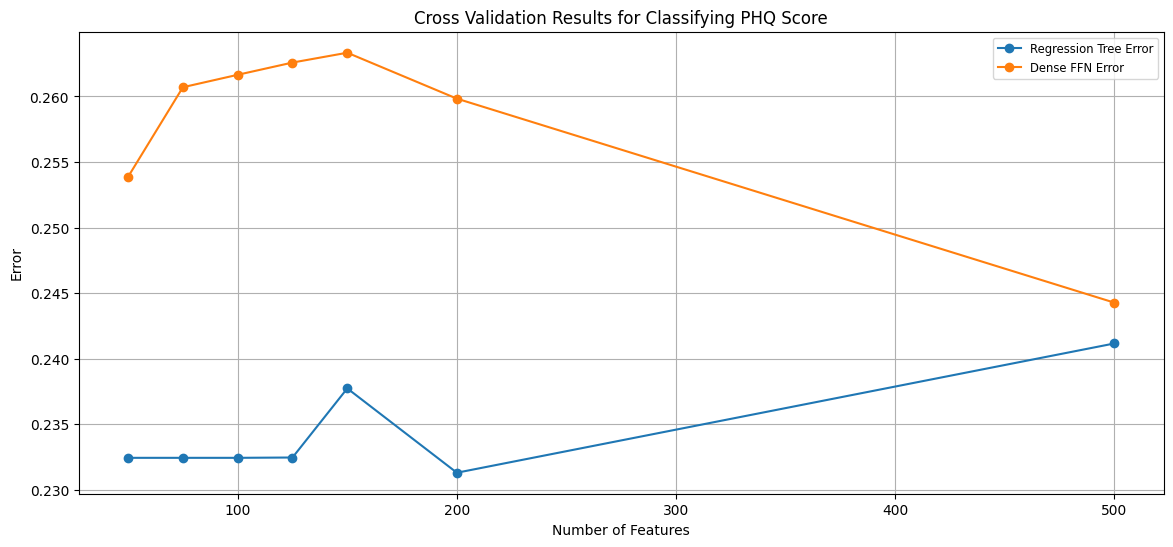

In [191]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14, 6))
plt.title("Cross Validation Results for Classifying PHQ Score")

# Plot accuracy metrics
plt.plot(numberOfFeatures, reTree, label="Regression Tree Error", marker='o')
plt.plot(numberOfFeatures, reDL, label="Dense FFN Error", marker='o')

# Add labels, legend, and grid
plt.xlabel("Number of Features")
plt.ylabel("Error")
plt.legend(loc='best', fontsize='small')
plt.grid(True)

# Show plot
plt.show()

In [192]:
#Looking for subgroup accuracy using the best model

from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

phqDF = final_df.drop(["raceData", "condition", "genderData"], axis=1)

targetPHQ = pd.DataFrame([phqDF.pop("participant_id"), phqDF.pop("phq_score").astype(int)]).T

phqFolds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(phqDF):
    train_fold = phqDF.iloc[train_index]
    test_fold = phqDF.iloc[test_index]
    train_target_fold = targetPHQ.iloc[train_index]["phq_score"]
    test_target_fold = targetPHQ.iloc[test_index]
    phqFolds.append((train_fold, train_target_fold, test_fold, test_target_fold))


minDLReNumFeatures = 125
minTreeReNumFeatures = 50


nIdxTree = top_n_idx(phqCorr, minTreeReNumFeatures)
nColsTree = phqDF.columns[nIdxTree]

nIdxDL = top_n_idx(phqCorr, minDLReNumFeatures)
nColsDL = phqDF.columns[nIdxDL]

# Iterate through the folds and actually store the predicition for each participant

predictionsDF = pd.DataFrame(columns=["participant_id", "phq_score_tree", "phq_score_dl"])

for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(phqFolds):

    #match the predictions with the participant ID

    train_fold_tree = train_fold[nColsTree]
    test_fold_tree = test_fold[nColsTree]

    
    # train XGBoost model
    xgb_regressor = xgb.XGBRegressor()
    xgb_regressor.fit(train_fold_tree, train_target_fold)


    predTree = xgb_regressor.predict(test_fold_tree)
    
    #concatenate the predictions to the to the test_target_fold
    test_target_fold["phq_score_tree"] = predTree

    # train DL model
    train_fold_dl = train_fold[nColsDL]
    test_fold_dl = test_fold[nColsDL]

    FNN = getDLModel(train_fold_dl.shape[1])

    FNN.fit(train_fold_dl.astype(float), train_target_fold.astype(float), epochs=100, verbose=0)

    predDL = FNN.predict(test_fold_dl).flatten()

    #concatenate the predictions to the to the test_target_fold
    test_target_fold["phq_score_dl"] = predDL

    predictionsDF = pd.concat([predictionsDF, test_target_fold], axis=0)

# predDF
print(predictionsDF.head(30))

2/2 [==============================] - 0s 2ms/step
    participant_id  phq_score_tree  phq_score_dl phq_score
5              391        4.577466     -0.001629         9
9              396        2.640895     -0.001374         5
15             403        9.636270     -0.000629         0
16             404        0.406542     -0.001586         0
18             406        1.204130     -0.000987         2
19             407        2.594492     -0.000491         3
24             412        0.872530     -0.001204        12
30             418        8.056828     -0.002974        10
42             430        1.987559     -0.000431         3
45             433        0.160977     -0.001266        10
56             444        1.583624     -0.005700         7
65             453        3.601342      0.000362        17
66             454        1.054924     -0.001993         1
67             455        2.205806     -0.003506         1
68             456        0.176410     -0.001609         6
75   

In [193]:
predictionsDF = predictionsDF.sort_values(by=["participant_id"])

#combine the predictions with the demographic data

#create a dataframe to store the predictions. Has participant ID, race, gender, PHQ score, and the predicted PHQ score for both models
predDF = final_df[["participant_id", "raceData", "genderData", "phq_score"]]

predDF = pd.merge(predDF, predictionsDF, on="participant_id")

#map race from number to label
raceMap = {
    1: "African American",
    2: "Asian",
    3: "White/Caucasian",
    4: "Hispanic",
    5: "Native American",
    6: "Native Hawaiian/Oth Pacific Islander",
    7: "Other"
}

genderMap = {
    1: "Male",
    2: "Female"
}

#apply mapping to dataframe
predDF["raceData"] = predDF["raceData"].astype(int).map(raceMap)
predDF["genderData"] = predDF["genderData"].map(genderMap)

print(predDF.head())

  participant_id          raceData genderData  phq_score_x  phq_score_tree  \
0            386   White/Caucasian     Female           11        1.643345   
1            387  African American       Male            2        5.239750   
2            388          Hispanic       Male           17       11.492045   
3            389  African American       Male           14        3.699225   
4            390   White/Caucasian       Male            9        2.076926   

   phq_score_dl phq_score_y  
0      1.636127          11  
1     -0.005512           2  
2      1.746682          17  
3      1.769022          14  
4      1.647175           9  


For Females the tree model had an absolute relative error of 0.23286133306537418 and the DL model had an absolute relative error of 0.2520519380456692
For Males the tree model had an absolute relative error of 0.2170412719897602 and the DL model had an absolute relative error of 0.26734356548027
For White/Caucasian participants the tree model had an absolute relative error of 0.20992928611370787 and the DL model had an absolute relative error of 0.26548317983324016
For African American participants the tree model had an absolute relative error of 0.2167655823892915 and the DL model had an absolute relative error of 0.21979514074689233
For Hispanic participants the tree model had an absolute relative error of 0.23460225095416462 and the DL model had an absolute relative error of 0.25074695801214786
For Other participants the tree model had an absolute relative error of 0.22794415256629388 and the DL model had an absolute relative error of 0.3362307443780203
For Asian participants the tr

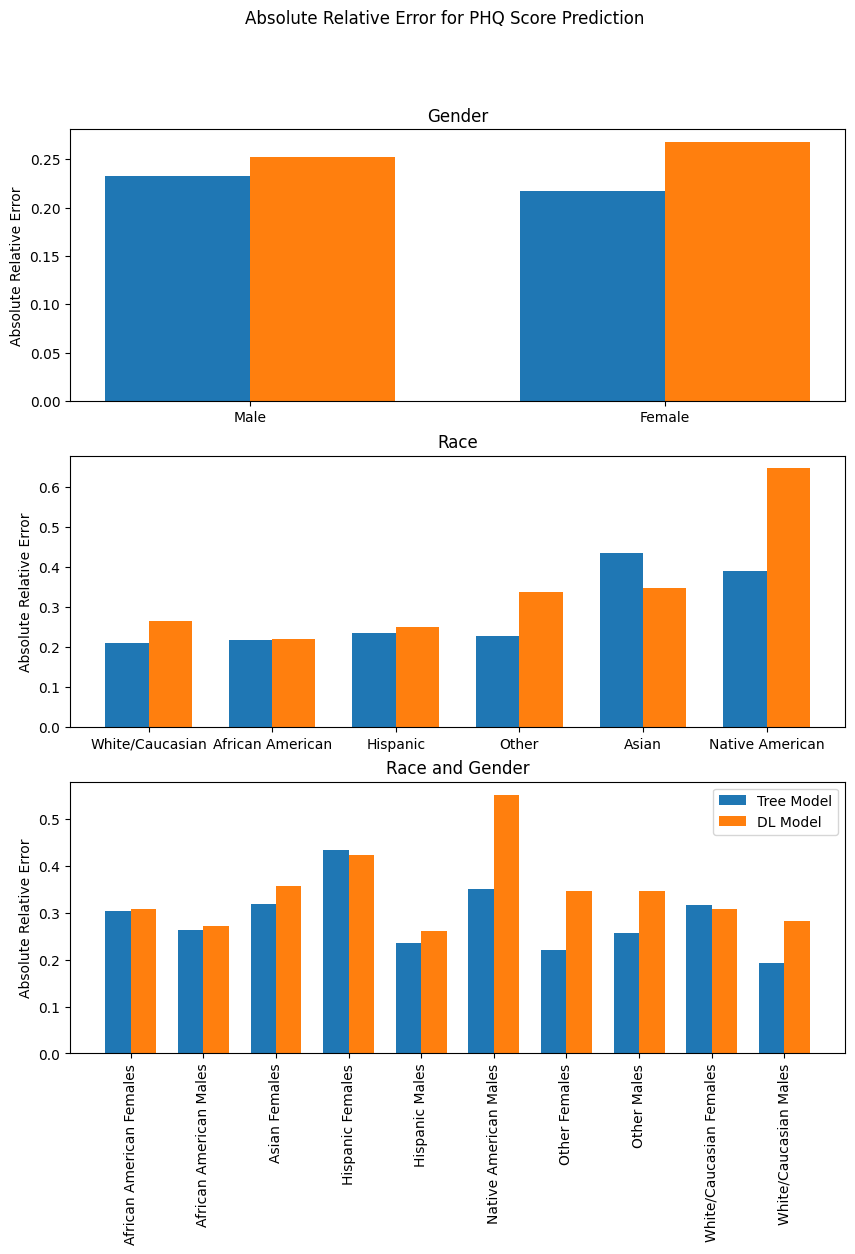

In [194]:
#iterate over each gender/race group and calculate the mean absolute error

grouped = predDF.groupby(["raceData", "genderData"])

genderTreeErrors = []
genderDLErrors = []

for gender in predDF["genderData"].unique():

    if len(predDF[predDF["genderData"] == gender]) < 2:
        continue


    treeError = absRelErr(predDF[predDF["genderData"] == gender]["phq_score_tree"], predDF[predDF["genderData"] == gender]["phq_score_x"])
    dlError = absRelErr(predDF[predDF["genderData"] == gender]["phq_score_dl"], predDF[predDF["genderData"] == gender]["phq_score_x"])

    genderTreeErrors.append(treeError[0])
    genderDLErrors.append(dlError[0])



    print(f"For {gender}s the tree model had an absolute relative error of {treeError[0]} and the DL model had an absolute relative error of {dlError[0]}")

raceCat = []
raceTreeErrors = []
raceDLErrors = []

for race in predDF["raceData"].unique():

    if len(predDF[predDF["raceData"] == race]) < 2:
        continue

    treeError = absRelErr(predDF[predDF["raceData"] == race]["phq_score_tree"], predDF[predDF["raceData"] == race]["phq_score_x"])
    dlError = absRelErr(predDF[predDF["raceData"] == race]["phq_score_dl"], predDF[predDF["raceData"] == race]["phq_score_x"])

    raceCat.append(race)
    raceTreeErrors.append(treeError[0])
    raceDLErrors.append(dlError[0])

    print(f"For {race} participants the tree model had an absolute relative error of {treeError[0]} and the DL model had an absolute relative error of {dlError[0]}")


raceGenderCat = []
raceGenderTreeErrors = []
raceGenderDLErrors = []

for (race, gender), group in grouped:

    if(race == "Asian" and gender == "Male"):
        continue

    if len(group) < 2:
        continue

    treeError = absRelErr(group["phq_score_tree"], group["phq_score_x"])
    dlError = absRelErr(group["phq_score_dl"], group["phq_score_x"])

    raceGenderCat.append(f"{race} {gender}s")
    raceGenderTreeErrors.append(treeError[0])
    raceGenderDLErrors.append(dlError[0])


#plot the results as a bar chart

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(10, 12))
fig.suptitle("Absolute Relative Error for PHQ Score Prediction")

# Define the width of the bars
bar_width = 0.35

# Create positions for the bars
index = np.arange(len(genderTreeErrors))

# Plot Gender
ax[0].bar(index, genderTreeErrors, bar_width, label="Tree Model")
ax[0].bar(index + bar_width, genderDLErrors, bar_width, label="DL Model")
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(["Male", "Female"])
ax[0].set(ylabel="Absolute Relative Error")
ax[0].set_title("Gender")

# Plot Race
index = np.arange(len(raceTreeErrors))
ax[1].bar(index, raceTreeErrors, bar_width, label="Tree Model")
ax[1].bar(index + bar_width, raceDLErrors, bar_width, label="DL Model")
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(raceCat)
ax[1].set(ylabel="Absolute Relative Error")
ax[1].set_title("Race")

# Plot Race and Gender
index = np.arange(len(raceGenderTreeErrors))
ax[2].bar(index, raceGenderTreeErrors, bar_width, label="Tree Model")
ax[2].bar(index + bar_width, raceGenderDLErrors, bar_width, label="DL Model")
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(raceGenderCat)
ax[2].set(ylabel="Absolute Relative Error")
ax[2].set_title("Race and Gender")
# Rotate the x labels 90 degrees
plt.xticks(rotation=90)

plt.legend()
plt.show()

## Part e: Mitigating bias via reducing socio-demographic dependencies in features.

In [195]:
#Repeat above but remove the 50 most correlated features of race and gender
raceDF = final_df.drop(["phq_score", "condition", "participant_id", "genderData"], axis=1)

targetRace = raceDF.pop("raceData")

raceCorr = []

for i, (cols) in enumerate(raceDF.columns):

    corr, p = pearsonr(raceDF[cols], targetRace)
    if np.isnan(corr):
        corr = 0
    raceCorr.append(corr)


genderDF = final_df.drop(["phq_score", "condition", "participant_id", "raceData"], axis=1).dropna()

targetGender = genderDF.pop("genderData")

genderCorr = []

for i, (cols) in enumerate(genderDF.columns):

    corr, p = pearsonr(genderDF[cols], targetGender)
    if np.isnan(corr):
        corr = 0
    genderCorr.append(corr)

In [196]:
#Looking for subgroup accuracy using the best model

from sklearn.model_selection import KFold

# initialize the KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

phqDF = final_df.drop(["race", "condition", "genderData"], axis=1)

targetPHQ = pd.DataFrame([phqDF.pop("participant_id"), phqDF.pop("phq_score").astype(int)]).T

phqFolds = []

# split the DataFrame into 5 folds
for train_index, test_index in kf.split(phqDF):
    train_fold = phqDF.iloc[train_index]
    test_fold = phqDF.iloc[test_index]
    train_target_fold = targetPHQ.iloc[train_index]["phq_score"]
    test_target_fold = targetPHQ.iloc[test_index]
    phqFolds.append((train_fold, train_target_fold, test_fold, test_target_fold))

minDLReNumFeatures = 125
minTreeReNumFeatures = 50

nIdxTree = top_n_idx(phqCorr, minTreeReNumFeatures)
nColsTree = phqDF.columns[nIdxTree]

nIdxDL = top_n_idx(phqCorr, minDLReNumFeatures)
nColsDL = phqDF.columns[nIdxDL]

nIdxTreeRace = top_n_idx(raceCorr, 50)
nColsTreeRace = phqDF.columns[nIdxTreeRace]

nIdxDLRace = top_n_idx(raceCorr, 50)
nColsDLRace = phqDF.columns[nIdxDLRace]

nIdxTreeGender = top_n_idx(genderCorr, 50)
nColsTreeGender = phqDF.columns[nIdxTreeGender]

nIdxDLGender = top_n_idx(genderCorr, 50)
nColsDLGender = phqDF.columns[nIdxDLGender]

#Remove the race and gender columns from the phq columns
nColsTree = [x for x in nColsTree if x not in nColsTreeRace]
nColsDL = [x for x in nColsDL if x not in nColsDLRace]

nColsTree = [x for x in nColsTree if x not in nColsTreeGender]
nColsDL = [x for x in nColsDL if x not in nColsDLGender]

# Iterate through the folds and actually store the predicition for each participant
predictionsDF = pd.DataFrame(columns=["participant_id", "phq_score_tree", "phq_score_dl"])

for i, (train_fold, train_target_fold, test_fold, test_target_fold) in enumerate(phqFolds):

    #match the predictions with the participant ID
    train_fold_tree = train_fold[nColsTree]
    test_fold_tree = test_fold[nColsTree]

    # train XGBoost model
    xgb_regressor = xgb.XGBRegressor()
    xgb_regressor.fit(train_fold_tree, train_target_fold)

    predTree = xgb_regressor.predict(test_fold_tree)
    
    #concatenate the predictions to the to the test_target_fold
    test_target_fold["phq_score_tree"] = predTree

    # train DL model
    train_fold_dl = train_fold[nColsDL]
    test_fold_dl = test_fold[nColsDL]

    FNN = getDLModel(train_fold_dl.shape[1])

    FNN.fit(train_fold_dl.astype(float), train_target_fold.astype(float), epochs=100, verbose=0)

    predDL = FNN.predict(test_fold_dl).flatten()

    #concatenate the predictions to the to the test_target_fold
    test_target_fold["phq_score_dl"] = predDL

    predictionsDF = pd.concat([predictionsDF, test_target_fold], axis=0)

# predDF
print(predictionsDF.head(30))

2/2 [==============================] - 0s 2ms/step
    participant_id  phq_score_tree  phq_score_dl phq_score
5              391        1.242802      1.640251         9
9              396        3.935820      1.748783         5
15             403        8.962173      1.717167         0
16             404       11.239199      1.648041         0
18             406        2.139627      1.671465         2
19             407        0.830018      1.664665         3
24             412        7.872362      1.649469        12
30             418        2.275034      1.674221        10
42             430        9.743129      1.680897         3
45             433        2.554738      1.783230        10
56             444        9.401750      1.787016         7
65             453       14.866764      1.755968        17
66             454        2.139627      1.634157         1
67             455        4.330151      1.723138         1
68             456        1.199376      1.694957         6
75   

In [197]:
predictionsDF = predictionsDF.sort_values(by=["participant_id"])

#combine the predictions with the demographic data

#create a dataframe to store the predictions. Has participant ID, race, gender, PHQ score, and the predicted PHQ score for both models
predDF = final_df[["participant_id", "raceData", "genderData", "phq_score"]]

predDF = pd.merge(predDF, predictionsDF, on="participant_id")

#map race from number to label
raceMap = {
    1: "African American",
    2: "Asian",
    3: "White/Caucasian",
    4: "Hispanic",
    5: "Native American",
    6: "Native Hawaiian/Oth Pacific Islander",
    7: "Other"
}

genderMap = {
    1: "Male",
    2: "Female"
}

#apply mapping to dataframe
predDF["raceData"] = predDF["raceData"].astype(int).map(raceMap)
predDF["genderData"] = predDF["genderData"].map(genderMap)

print(predDF.head(30))

   participant_id          raceData genderData  phq_score_x  phq_score_tree  \
0             386   White/Caucasian     Female           11        2.200469   
1             387  African American       Male            2        3.811723   
2             388          Hispanic       Male           17        0.414354   
3             389  African American       Male           14        4.089072   
4             390   White/Caucasian       Male            9        2.804458   
5             391          Hispanic     Female            9        1.242802   
6             392   White/Caucasian     Female            1        3.559125   
7             393          Hispanic       Male            2        3.547829   
8             395          Hispanic     Female            7        2.772179   
9             396   White/Caucasian       Male            5        3.935820   
10            397          Hispanic       Male            5        3.670734   
11            399             Other     Female      

For Females the tree model had an absolute relative error of 0.2683021522032415 and the DL model had an absolute relative error of 0.2697259421603353
For Males the tree model had an absolute relative error of 0.30076084463257097 and the DL model had an absolute relative error of 0.2651886528703428
For White/Caucasian participants the tree model had an absolute relative error of 0.27676147493449127 and the DL model had an absolute relative error of 0.2658934922321588
For African American participants the tree model had an absolute relative error of 0.24038624313469112 and the DL model had an absolute relative error of 0.2346440319116091
For Hispanic participants the tree model had an absolute relative error of 0.34897101620183796 and the DL model had an absolute relative error of 0.25697305204939247
For Other participants the tree model had an absolute relative error of 0.32653609732786815 and the DL model had an absolute relative error of 0.3291840143470715
For Asian participants the t

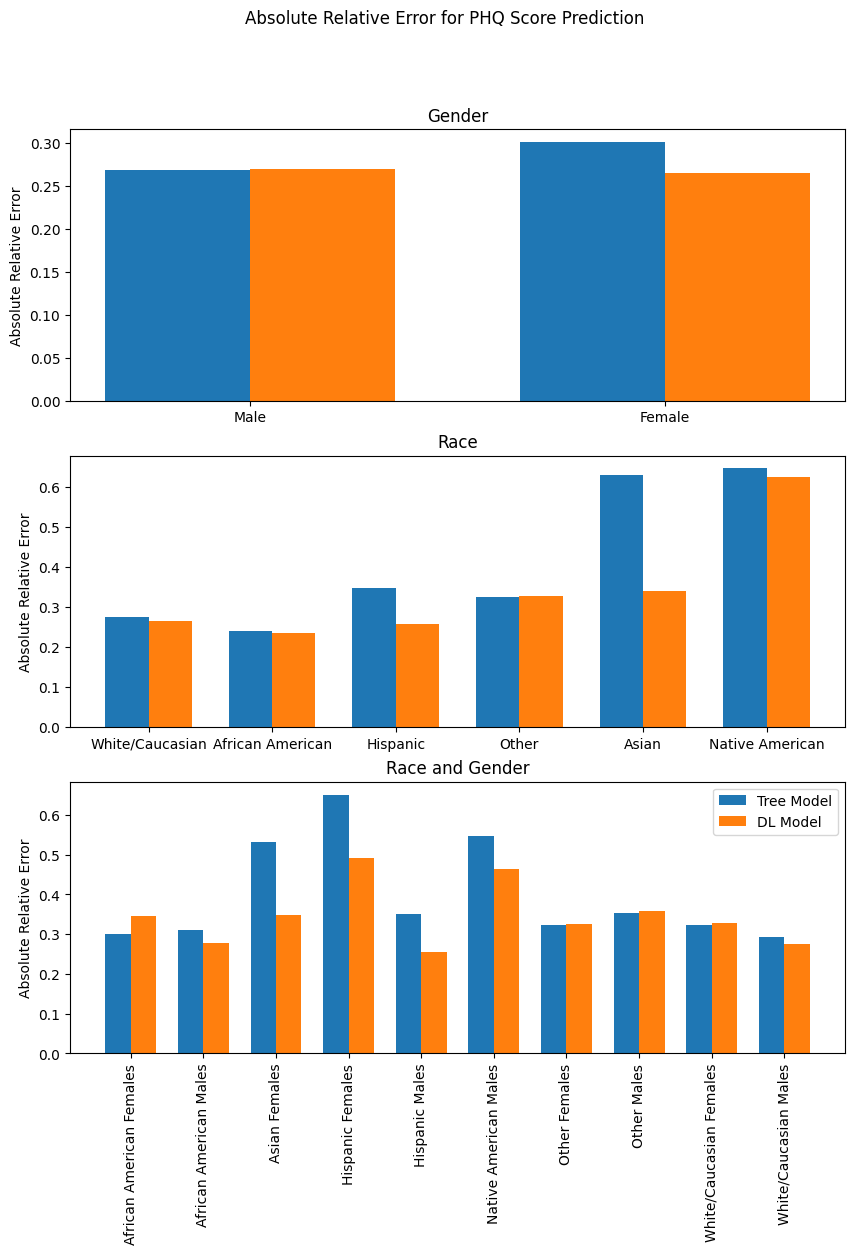

In [ ]:
#iterate over each gender/race group and calculate the mean absolute error

grouped = predDF.groupby(["raceData", "genderData"])

genderTreeErrors = []
genderDLErrors = []

for gender in predDF["genderData"].unique():

    if len(predDF[predDF["genderData"] == gender]) < 2:
        continue


    treeError = absRelErr(predDF[predDF["genderData"] == gender]["phq_score_tree"], predDF[predDF["genderData"] == gender]["phq_score_x"])
    dlError = absRelErr(predDF[predDF["genderData"] == gender]["phq_score_dl"], predDF[predDF["genderData"] == gender]["phq_score_x"])

    genderTreeErrors.append(treeError[0])
    genderDLErrors.append(dlError[0])



    print(f"For {gender}s the tree model had an absolute relative error of {treeError[0]} and the DL model had an absolute relative error of {dlError[0]}")

raceCat = []
raceTreeErrors = []
raceDLErrors = []

for race in predDF["raceData"].unique():

    if len(predDF[predDF["raceData"] == race]) < 2:
        continue

    treeError = absRelErr(predDF[predDF["raceData"] == race]["phq_score_tree"], predDF[predDF["raceData"] == race]["phq_score_x"])
    dlError = absRelErr(predDF[predDF["raceData"] == race]["phq_score_dl"], predDF[predDF["raceData"] == race]["phq_score_x"])

    raceCat.append(race)
    raceTreeErrors.append(treeError[0])
    raceDLErrors.append(dlError[0])

    print(f"For {race} participants the tree model had an absolute relative error of {treeError[0]} and the DL model had an absolute relative error of {dlError[0]}")


raceGenderCat = []
raceGenderTreeErrors = []
raceGenderDLErrors = []

for (race, gender), group in grouped:

    if(race == "Asian" and gender == "Male"):
        continue

    if len(group) < 2:
        continue

    treeError = absRelErr(group["phq_score_tree"], group["phq_score_x"])
    dlError = absRelErr(group["phq_score_dl"], group["phq_score_x"])

    raceGenderCat.append(f"{race} {gender}s")
    raceGenderTreeErrors.append(treeError[0])
    raceGenderDLErrors.append(dlError[0])


#plot the results as a bar chart

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize=(10, 12))
fig.suptitle("Absolute Relative Error for PHQ Score Prediction")

# Define the width of the bars
bar_width = 0.35

# Create positions for the bars
index = np.arange(len(genderTreeErrors))

# Plot Gender
ax[0].bar(index, genderTreeErrors, bar_width, label="Tree Model")
ax[0].bar(index + bar_width, genderDLErrors, bar_width, label="DL Model")
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(["Male", "Female"])
ax[0].set(ylabel="Absolute Relative Error")
ax[0].set_title("Gender")

# Plot Race
index = np.arange(len(raceTreeErrors))
ax[1].bar(index, raceTreeErrors, bar_width, label="Tree Model")
ax[1].bar(index + bar_width, raceDLErrors, bar_width, label="DL Model")
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(raceCat)
ax[1].set(ylabel="Absolute Relative Error")
ax[1].set_title("Race")

# Plot Race and Gender
index = np.arange(len(raceGenderTreeErrors))
ax[2].bar(index, raceGenderTreeErrors, bar_width, label="Tree Model")
ax[2].bar(index + bar_width, raceGenderDLErrors, bar_width, label="DL Model")
ax[2].set_xticks(index + bar_width / 2)
ax[2].set_xticklabels(raceGenderCat)
ax[2].set(ylabel="Absolute Relative Error")
ax[2].set_title("Race and Gender")
# Rotate the x labels 90 degrees
plt.xticks(rotation=90)

plt.legend()
plt.show()

## Part f: Experimenting with transformers
For this I tried using both the minGPT implementation and models from hugging face but it was hard to fine tune and prompt all the models i tried. Here is a list of models and their issues:
* minGPT - couldnt get it to finetune for the correct output, let it run on my machine for 2 hrs and it didnt finish finetuning
    * prompt techniques like few shot and chain of reasoning just made it generate text based off the prompts
* https://huggingface.co/neuralmagic/Meta-Llama-3.1-8B-Instruct-quantized.w4a16: couldnt get it to run due to random errors with pytorch and tensorflow in the environment
* https://huggingface.co/meta-llama/Llama-2-7b-hf: too large to run on my personal machine with the tokens needed for output strings
* Intel/dynamic_tinybert: will only respond to questions about bert, anything else is returns the context given
* siebert/sentiment-roberta-large-english: this was the final try where I created the transcripts dataset and tried to infer from the scores it gave

If it was successful the plan wouldve been to to use the m and n most features from part d/e to see how the model fairs

In [45]:
transcripts_df = pd.DataFrame(columns=["Participant_ID", "transcript"])
for id, transcript in combined_transcripts.items():
    temp = pd.DataFrame({"Participant_ID": [id], "transcript": transcript})
    transcripts_df = pd.concat([transcripts_df, temp], ignore_index=True)

In [46]:
transcripts_df = pd.merge(transcripts_df, phq_scores_data, on="Participant_ID", how="inner")
transcripts_df

,Participant_ID,transcript,PHQ_Score
0,423,okay and please yes feeling well where are you...,0
1,436,that was big yes I'm doing fine Mexico when I ...,0
2,447,yeah that's perfectly fine I'm feeling great i...,1
3,452,official say bye and then you're going to pres...,1
4,396,okay thank you thanks for coming in today crea...,5
...,...,...,...
129,466,I was that man when do I talk okay okay okay y...,9
130,633,and she's a speech recognition so like recogni...,10
131,484,okay yes I'm doing well I was born in Oakland ...,9
132,491,do I still have to put my cat okay yes how ove...,8


In [32]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

In [83]:
model_name = "siebert/sentiment-roberta-large-english"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [84]:
def compute_sentiment_score(text):

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=-1)
    positive_prob = probs[0][1].item()
    score = positive_prob * 100

    return score

In [85]:
def analyze_transcript(transcript, chunk_size):

    tokens = tokenizer(transcript, return_tensors="pt", truncation=False)
    input_ids = tokens["input_ids"][0]

    num_chunks = (len(input_ids) + chunk_size - 1) // chunk_size
    scores = []

    for i in range(num_chunks):

        chunk_ids = input_ids[i*chunk_size:(i+1)*chunk_size]
        chunk_text = tokenizer.decode(chunk_ids, skip_special_tokens=True)

        score = compute_sentiment_score(chunk_text)
        scores.append(score)

    overall_score = np.mean(scores)
    return overall_score

In [86]:
p1 = f"""Transcript= {transcripts_df["transcript"][0]} : Depression Severity=0"""

p2 =   f"""Transcript= {transcripts_df["transcript"][1]} : Depression Severity=0"""

p3 = f"""Transcript= {transcripts_df["transcript"][10]} : Depression Severity=19"""

p4 = f"""Transcript= {transcripts_df["transcript"][14]} : Depression Severity=7"""

p5 = f"""Transcript= {transcripts_df["transcript"][20]} : Give a depression score for this transcript: """
prompts = [p1 + p2 + p3 + p4 + p5]

In [87]:
scores = []
for p in prompts:
    score = analyze_transcript(p, 4096)
    scores.append(score)

adjusted_scores = [60 * (score / 100) + 0 for score in scores]
print(adjusted_scores)

Token indices sequence length is longer than the specified maximum sequence length for this model (8797 > 512). Running this sequence through the model will result in indexing errors


[59.74992513656616]
